# Import Libraries

In [110]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime as dt
from datetime import timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
import os
import cx_Oracle
import time
from scipy.stats import binom
os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\GM WO Product Pillar")

# Read Data

In [2]:
# conn = cx_Oracle.connect('HCIN_Jainr1[AP_UWI]','Saber@1989!1','INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
# query = """
# select * from ak_tmp_gm_wo_pp_dump
# ;
# """

# data = pd.read_sql(query, conn)
# data.to_csv(os.getcwd()+"\Data Files\combined.csv", index = False)

In [40]:
df= pd.read_csv(os.getcwd()+"\Data Files\export.csv")

In [41]:
df.head()

,SKP_CREDIT_CASE,POS_AUG20_DND,POS_AUG20_VODAFONE,POS_AUG20_PAYU,POS_AUG20_GEO,POS_AUG20_INTERNAL,POS_AUG20_PRODUCT,POS_MAR20_CIBIL_LGBM,POS_AUG19_LADDER,POS_AUG20_GM,...,CLIENT_EXI_3M,SCORE_CB,FLAG_1PCT_PHANTOM,DECISION_OVERALL,RISK_AGRF10,RISK_AGRF30,RISK_AGRF60,RISK_FPD10,RISK_FPD30,RISK_FSPD30
0,306282502,-2.630188,-3.131907,-0.026942,0.032083,-1.739697,-2.491208,-3.460000,-2.587039,-4.217360,...,N,-1.0,1,Approved,1,1,1,0,0,0
1,306283929,-2.796292,-3.131907,-0.026942,0.032083,-2.206292,-2.109609,-2.259395,-2.589282,-3.258493,...,N,-1.0,1,Approved,1,1,1,0,0,0
2,306284197,-2.630188,-3.131907,-0.026942,0.032083,-1.588279,-2.640708,-3.460000,-2.587039,-4.229386,...,N,-1.0,1,Approved,1,1,1,0,0,0
3,306284217,-2.630188,-3.131907,0.374091,0.032083,-2.116562,-2.010056,-3.506836,-2.733354,-4.624282,...,N,755.0,1,Approved,1,1,1,0,0,0
4,306284631,-2.630188,-3.131907,-0.026942,0.032083,-0.986074,-2.253607,-3.740557,-2.587039,-3.707889,...,N,-1.0,1,Approved,1,1,1,0,0,0


# Define Key Variables

In [42]:
TIME_CREATION_DATE = 'TIME_DECISION_DATE'
TARGET = 'RISK_FPD30'
PHANTOMAS_FLAG = 'FLAG_1PCT_PHANTOM'
AGRF_FLAG = "RISK_AGRF30"

# Format Date Columns

In [43]:
df[TIME_CREATION_DATE] = pd.to_datetime(df[TIME_CREATION_DATE], format = '%d-%m-%y')
df["MONTH"] = df[TIME_CREATION_DATE].dt.strftime("%Y-%m")

In [66]:
df.columns

Index(['SKP_CREDIT_CASE', 'POS_AUG20_DND', 'POS_AUG20_VODAFONE',
       'POS_AUG20_PAYU', 'POS_AUG20_GEO', 'POS_AUG20_INTERNAL',
       'POS_AUG20_PRODUCT', 'POS_MAR20_CIBIL_LGBM', 'POS_AUG19_LADDER',
       'POS_AUG20_GM', 'POS_AUG20_GM_WO_PRODUCT', 'TIME_DECISION_DATE',
       'CLIENT_EXI_3M', 'SCORE_CB', 'FLAG_1PCT_PHANTOM', 'DECISION_OVERALL',
       'RISK_AGRF10', 'RISK_AGRF30', 'RISK_AGRF60', 'RISK_FPD10', 'RISK_FPD30',
       'RISK_FSPD30', 'MONTH', 'GM_LR_WO_PP'],
      dtype='object')

In [44]:
df.head()

,SKP_CREDIT_CASE,POS_AUG20_DND,POS_AUG20_VODAFONE,POS_AUG20_PAYU,POS_AUG20_GEO,POS_AUG20_INTERNAL,POS_AUG20_PRODUCT,POS_MAR20_CIBIL_LGBM,POS_AUG19_LADDER,POS_AUG20_GM,...,SCORE_CB,FLAG_1PCT_PHANTOM,DECISION_OVERALL,RISK_AGRF10,RISK_AGRF30,RISK_AGRF60,RISK_FPD10,RISK_FPD30,RISK_FSPD30,MONTH
0,306282502,-2.630188,-3.131907,-0.026942,0.032083,-1.739697,-2.491208,-3.460000,-2.587039,-4.217360,...,-1.0,1,Approved,1,1,1,0,0,0,2020-06
1,306283929,-2.796292,-3.131907,-0.026942,0.032083,-2.206292,-2.109609,-2.259395,-2.589282,-3.258493,...,-1.0,1,Approved,1,1,1,0,0,0,2020-06
2,306284197,-2.630188,-3.131907,-0.026942,0.032083,-1.588279,-2.640708,-3.460000,-2.587039,-4.229386,...,-1.0,1,Approved,1,1,1,0,0,0,2020-06
3,306284217,-2.630188,-3.131907,0.374091,0.032083,-2.116562,-2.010056,-3.506836,-2.733354,-4.624282,...,755.0,1,Approved,1,1,1,0,0,0,2020-06
4,306284631,-2.630188,-3.131907,-0.026942,0.032083,-0.986074,-2.253607,-3.740557,-2.587039,-3.707889,...,-1.0,1,Approved,1,1,1,0,0,0,2020-06


# Split Train Test Data

### Define Predictors

In [45]:
x_columns = ["POS_AUG20_DND", "POS_AUG20_VODAFONE", "POS_AUG20_PAYU", "POS_AUG20_GEO", 
             "POS_AUG20_INTERNAL", "POS_AUG19_LADDER"]

In [46]:
for x in x_columns: 
    print(x, df[x].isna().sum())

POS_AUG20_DND 0
POS_AUG20_VODAFONE 0
POS_AUG20_PAYU 0
POS_AUG20_GEO 0
POS_AUG20_INTERNAL 0
POS_AUG19_LADDER 128560


In [47]:
df.dropna(subset = x_columns, inplace = True)

In [48]:
df.TIME_DECISION_DATE.min()

Timestamp('2020-06-01 00:00:00')

In [49]:
df_train = df[(df[TIME_CREATION_DATE] <= pd.datetime(2020,11,30))]
df_test = df[(df[TIME_CREATION_DATE] > pd.datetime(2020,11,30))]

print("Event rate in train set :", '{:,.2%}'.format(sum(df_train[TARGET]) / len(df_train[TARGET])))
print("Train set shape:",df_train[x_columns].shape)
print("Event rate in test set :", '{:,.2%}'.format(sum(df_test[TARGET]) / len(df_test[TARGET])))
print("Train set shape:",df_test[x_columns].shape)

Event rate in train set : 2.55%
Train set shape: (21839, 6)
Event rate in test set : 0.28%
Train set shape: (244482, 6)


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


# Build Logistic Model

### Fit model only on Phantomas Population

In [50]:
df_train = df_train[df_train[PHANTOMAS_FLAG]==1]

### L1 Penalty Hyper Parameter Optimization

In [51]:
param_grid = {'C':np.exp(np.arange(-7,3,0.01))}

kfolds = StratifiedKFold(3, shuffle = True, random_state=1)
comb=LogisticRegression(penalty = 'l1', solver = 'liblinear')

rcv = RandomizedSearchCV(estimator = comb, param_distributions=param_grid, scoring=['roc_auc'], n_iter = 10,
    cv=kfolds.split(df_train[x_columns],df_train[TARGET]), verbose=0, random_state=1,
    refit = 'roc_auc', return_train_score=True, error_score = 0)

Randomized search..
Randomized search time: 5.071551322937012
{'C': 0.5769498103804074}


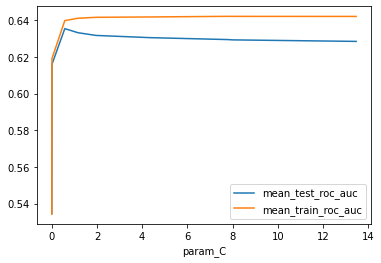

In [52]:
#Calculate Gini Lift Logistic Regression
print("Randomized search..")
search_time_start = time.time()
rcv.fit(df_train[x_columns], df_train[TARGET])
print("Randomized search time:", time.time() - search_time_start)
params = rcv.best_params_   #get best parameters
dic=rcv.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 

tmp1= pd.DataFrame(dic)[["param_C","mean_test_roc_auc","mean_train_roc_auc"]].sort_values(by = 'param_C')
tmp1.plot(x="param_C")
print(params)

### Logistic Model With optimized Hyperparameters 

In [53]:
bst = LogisticRegression(penalty = 'l1', C=params['C'], solver = 'liblinear')

bst.fit(df_train[x_columns], df_train[TARGET])

ypred_train = bst.predict_proba(df_train[x_columns])[:, 1]
ypred_test = bst.predict_proba(df_test[x_columns])[:, 1]
df["GM_LR_WO_PP"] =  bst.predict_proba(df[x_columns])[:, 1]
print("Train GINI %.3f" % (2*roc_auc_score(df_train[TARGET], ypred_train)-1))
print("Test GINI %.3f" % (2*roc_auc_score(df_test[TARGET], ypred_test)-1))

Train GINI 0.278
Test GINI 0.231


### Save Model

In [54]:
pickle.dump(bst, open("gspn_model","wb"))
# bst =pickle.load(open(b"Fruits","rb"))

### Model Equation

In [55]:
pd.DataFrame({"column":x_columns,"coeffecient":bst.coef_[0]})

,column,coeffecient
0,POS_AUG20_DND,-0.269325
1,POS_AUG20_VODAFONE,0.414718
2,POS_AUG20_PAYU,-0.881673
3,POS_AUG20_GEO,0.000000
4,POS_AUG20_INTERNAL,0.492165
5,POS_AUG19_LADDER,0.774328


# Model Evaluation

### Check marginal Value add of Predictors

In [56]:
out = {'pred_list':[],'value':[]}

for y in range(len(x_columns)):
    tmp = {'pred':[],'value':[]}
    for x in x_columns:
        if x not in out['pred_list']:
            pred = out['pred_list'].copy()
            pred.append(x)
            bst = LogisticRegression(penalty = 'l1', C=params['C'], solver = 'liblinear')
            bst.fit(df_train[pred], df_train[TARGET])
            auc_cv = cross_val_score(bst, df_train[pred], df_train[TARGET], scoring='roc_auc', cv=3,n_jobs=-1)
            tmp["pred"].append(x)
            tmp["value"].append(2 * np.array(auc_cv).mean() - 1)
#             print("predictors :",pred,"Value :", 2 * np.array(auc_cv).mean() - 1)
    tmp_df = pd.DataFrame(tmp)
    out['pred_list'].append(tmp_df.loc[tmp_df["value"].idxmax(),"pred"])
    out['value'].append(tmp_df.loc[tmp_df["value"].idxmax(),"value"])    

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [57]:
out_df = pd.DataFrame(out)
out_df["increment"] = out_df.value-out_df.shift(1)["value"]
out_df

,pred_list,value,increment
0,POS_AUG19_LADDER,0.190147,NaN
1,POS_AUG20_INTERNAL,0.247128,0.056981
2,POS_AUG20_VODAFONE,0.257073,0.009945
3,POS_AUG20_PAYU,0.260484,0.003412
4,POS_AUG20_GEO,0.260356,-0.000128
5,POS_AUG20_DND,0.259461,-0.000895


# Dummy Score

In [126]:
df["GM_LR_WO_PP_DUMMY"] = 0.348692*df["POS_AUG20_DND"]+1.012241*df["POS_AUG20_VODAFONE"]+0.740426*df["POS_AUG20_INTERNAL"]+  0.789771*df["POS_AUG19_LADDER"]-0.72307*df["POS_AUG20_GEO"]-1.32087*df["POS_AUG20_PAYU"]+3.662210860407933

# MOM Gini

### MOM Gini (Phantomas Base: FPD10)

In [96]:
df_temp = df.dropna(subset = ["POS_AUG20_GM"])
df_temp = df_temp[df_temp[PHANTOMAS_FLAG]==1.0]
df_temp = df_temp[df_temp["RISK_AGRF10"]==1]
df_temp = df_temp[df_temp[TIME_CREATION_DATE]<=pd.datetime(2020,10,31)]
gini_dic = {}
predictor_list = []
target_variable = 'RISK_FPD10'
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "POS_AUG20_GM" not in gini_dic: 
            gini_dic["POS_AUG20_GM"] = []
        if "GM_LR_WO_PP_DUMMY" not in gini_dic: 
            gini_dic["GM_LR_WO_PP_DUMMY"] = []
        if "GM_LR_WO_PP" not in gini_dic: 
            gini_dic["GM_LR_WO_PP"] = []

        gini_dic["POS_AUG20_GM"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_AUG20_GM"])-1)*100)
        gini_dic["GM_LR_WO_PP_DUMMY"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP_DUMMY"])-1)*100)
        gini_dic["GM_LR_WO_PP"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


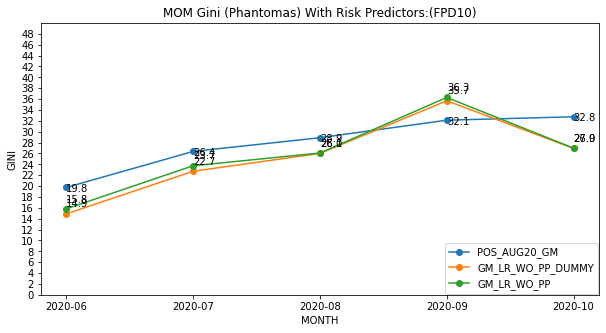

In [97]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["POS_AUG20_GM"], marker='o', scaley = False, label = "POS_AUG20_GM")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP_DUMMY"], marker='o', scaley = False, label = "GM_LR_WO_PP_DUMMY")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP"], marker='o', scaley = False, label = "GM_LR_WO_PP")

# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["POS_AUG20_GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["POS_AUG20_GM"][i]-0.8))
for i, txt in enumerate(gini_df["GM_LR_WO_PP_DUMMY"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP_DUMMY"][i]+1.2))
for i, txt in enumerate(gini_df["GM_LR_WO_PP"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini (Phantomas) With Risk Predictors:(FPD10)")
plt.show()

### MOM Gini (Phantomas Base: FPD30)

In [98]:
df_temp = df.dropna(subset = ["POS_AUG20_GM"])
df_temp = df_temp[df_temp[PHANTOMAS_FLAG]==1.0]
df_temp = df_temp[df_temp["RISK_AGRF30"]==1]
df_temp = df_temp[df_temp[TIME_CREATION_DATE]<=pd.datetime(2020,10,31)]
gini_dic = {}
predictor_list = []
target_variable = TARGET
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "POS_AUG20_GM" not in gini_dic: 
            gini_dic["POS_AUG20_GM"] = []
        if "GM_LR_WO_PP_DUMMY" not in gini_dic: 
            gini_dic["GM_LR_WO_PP_DUMMY"] = []
        if "GM_LR_WO_PP" not in gini_dic: 
            gini_dic["GM_LR_WO_PP"] = []

        gini_dic["POS_AUG20_GM"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_AUG20_GM"])-1)*100)
        gini_dic["GM_LR_WO_PP_DUMMY"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP_DUMMY"])-1)*100)
        gini_dic["GM_LR_WO_PP"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


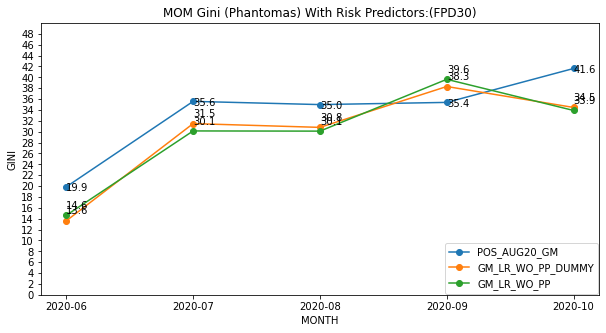

In [99]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["POS_AUG20_GM"], marker='o', scaley = False, label = "POS_AUG20_GM")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP_DUMMY"], marker='o', scaley = False, label = "GM_LR_WO_PP_DUMMY")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP"], marker='o', scaley = False, label = "GM_LR_WO_PP")

# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["POS_AUG20_GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["POS_AUG20_GM"][i]-0.8))
for i, txt in enumerate(gini_df["GM_LR_WO_PP_DUMMY"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP_DUMMY"][i]+1.2))
for i, txt in enumerate(gini_df["GM_LR_WO_PP"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini (Phantomas) With Risk Predictors:(FPD30)")
plt.show()

### MOM Gini (Phantomas Base: FSPD30)

In [100]:
df_temp = df.dropna(subset = ["POS_AUG20_GM"])
df_temp = df_temp[df_temp[PHANTOMAS_FLAG]==1.0]
df_temp = df_temp[df_temp["RISK_AGRF60"]==1]
df_temp = df_temp[df_temp[TIME_CREATION_DATE]<=pd.datetime(2020,10,31)]
gini_dic = {}
predictor_list = []
target_variable = 'RISK_FSPD30'
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "POS_AUG20_GM" not in gini_dic: 
            gini_dic["POS_AUG20_GM"] = []
        if "GM_LR_WO_PP_DUMMY" not in gini_dic: 
            gini_dic["GM_LR_WO_PP_DUMMY"] = []
        if "GM_LR_WO_PP" not in gini_dic: 
            gini_dic["GM_LR_WO_PP"] = []

        gini_dic["POS_AUG20_GM"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_AUG20_GM"])-1)*100)
        gini_dic["GM_LR_WO_PP_DUMMY"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP_DUMMY"])-1)*100)
        gini_dic["GM_LR_WO_PP"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


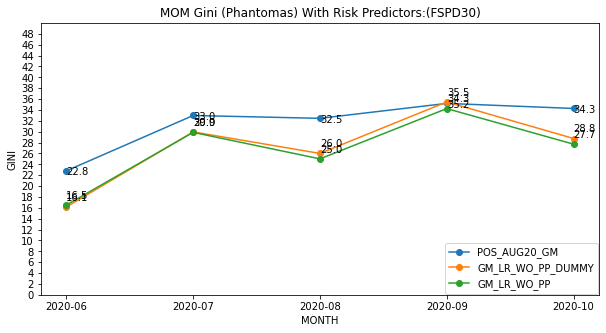

In [101]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["POS_AUG20_GM"], marker='o', scaley = False, label = "POS_AUG20_GM")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP_DUMMY"], marker='o', scaley = False, label = "GM_LR_WO_PP_DUMMY")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP"], marker='o', scaley = False, label = "GM_LR_WO_PP")

# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["POS_AUG20_GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["POS_AUG20_GM"][i]-0.8))
for i, txt in enumerate(gini_df["GM_LR_WO_PP_DUMMY"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP_DUMMY"][i]+1.2))
for i, txt in enumerate(gini_df["GM_LR_WO_PP"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini (Phantomas) With Risk Predictors:(FSPD30)")
plt.show()

In [127]:
print(df.POS_AUG20_GM.mean())
print(df.POS_AUG20_GM_WO_PRODUCT.mean())
print(df.GM_LR_WO_PP_DUMMY.mean())
print(np.log(df.GM_LR_WO_PP/(1-df.GM_LR_WO_PP)).mean())

-3.863868339026385
-3.9208758771391565
-4.111558131708275
-3.658665029834158


In [121]:
1/(1+np.exp(-df.POS_AUG20_GM.mean()))

0.020555272300450796

In [123]:
1/(1+np.exp(-(df.GM_LR_WO_PP_DUMMY.mean()-2.1218051395920674)))

0.016118177288641084

In [118]:
np.log(df.GM_LR_WO_PP/(1-df.GM_LR_WO_PP)).mean()

-3.658665029834158

In [125]:
5.784016-2.1218051395920674

3.662210860407933

### MOM Gini (Approved Base: FPD10)

In [102]:
df_temp = df.dropna(subset = ["POS_AUG20_GM"])
df_temp = df_temp[df_temp["RISK_AGRF10"]==1]
gini_dic = {}
predictor_list = []
target_variable = 'RISK_FPD10'
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "POS_AUG20_GM" not in gini_dic: 
            gini_dic["POS_AUG20_GM"] = []
        if "GM_LR_WO_PP_DUMMY" not in gini_dic: 
            gini_dic["GM_LR_WO_PP_DUMMY"] = []
        if "GM_LR_WO_PP" not in gini_dic: 
            gini_dic["GM_LR_WO_PP"] = []

        gini_dic["POS_AUG20_GM"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_AUG20_GM"])-1)*100)
        gini_dic["GM_LR_WO_PP_DUMMY"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP_DUMMY"])-1)*100)
        gini_dic["GM_LR_WO_PP"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

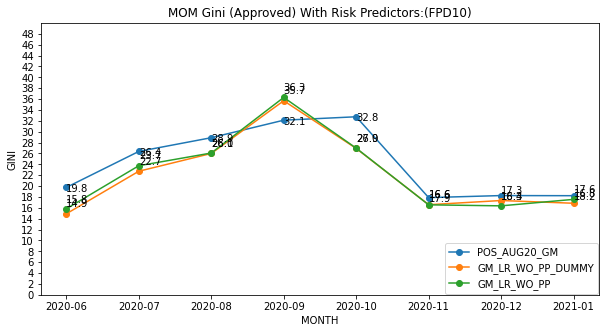

In [103]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["POS_AUG20_GM"], marker='o', scaley = False, label = "POS_AUG20_GM")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP_DUMMY"], marker='o', scaley = False, label = "GM_LR_WO_PP_DUMMY")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP"], marker='o', scaley = False, label = "GM_LR_WO_PP")

# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["POS_AUG20_GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["POS_AUG20_GM"][i]-0.8))
for i, txt in enumerate(gini_df["GM_LR_WO_PP_DUMMY"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP_DUMMY"][i]+1.2))
for i, txt in enumerate(gini_df["GM_LR_WO_PP"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:(FPD10)")
plt.show()

### MOM Gini (Approved Base: FPD30)

In [105]:
df_temp = df.dropna(subset = ["POS_AUG20_GM"])
df_temp = df_temp[df_temp["RISK_AGRF30"]==1]
gini_dic = {}
predictor_list = []
target_variable = 'RISK_FPD30'
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "POS_AUG20_GM" not in gini_dic: 
            gini_dic["POS_AUG20_GM"] = []
        if "GM_LR_WO_PP_DUMMY" not in gini_dic: 
            gini_dic["GM_LR_WO_PP_DUMMY"] = []
        if "GM_LR_WO_PP" not in gini_dic: 
            gini_dic["GM_LR_WO_PP"] = []

        gini_dic["POS_AUG20_GM"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_AUG20_GM"])-1)*100)
        gini_dic["GM_LR_WO_PP_DUMMY"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP_DUMMY"])-1)*100)
        gini_dic["GM_LR_WO_PP"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

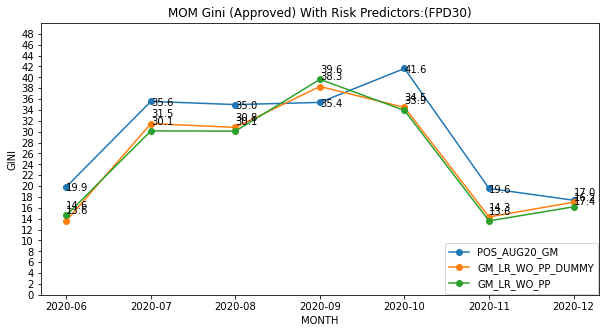

In [106]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["POS_AUG20_GM"], marker='o', scaley = False, label = "POS_AUG20_GM")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP_DUMMY"], marker='o', scaley = False, label = "GM_LR_WO_PP_DUMMY")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP"], marker='o', scaley = False, label = "GM_LR_WO_PP")

# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["POS_AUG20_GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["POS_AUG20_GM"][i]-0.8))
for i, txt in enumerate(gini_df["GM_LR_WO_PP_DUMMY"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP_DUMMY"][i]+1.2))
for i, txt in enumerate(gini_df["GM_LR_WO_PP"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:(FPD30)")
plt.show()

### MOM Gini (Approved Base: FSPD30)

In [108]:
df_temp = df.dropna(subset = ["POS_AUG20_GM"])
df_temp = df_temp[df_temp["RISK_AGRF60"]==1]
gini_dic = {}
predictor_list = []
target_variable = 'RISK_FSPD30'
for x in df_temp["MONTH"].unique():
    try:
        if "MONTH" not in gini_dic:
            gini_dic["MONTH"] = []
        if "POS_AUG20_GM" not in gini_dic: 
            gini_dic["POS_AUG20_GM"] = []
        if "GM_LR_WO_PP_DUMMY" not in gini_dic: 
            gini_dic["GM_LR_WO_PP_DUMMY"] = []
        if "GM_LR_WO_PP" not in gini_dic: 
            gini_dic["GM_LR_WO_PP"] = []

        gini_dic["POS_AUG20_GM"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["POS_AUG20_GM"])-1)*100)
        gini_dic["GM_LR_WO_PP_DUMMY"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP_DUMMY"])-1)*100)
        gini_dic["GM_LR_WO_PP"].append((2*roc_auc_score(df_temp[df_temp["MONTH"]==x][target_variable],df_temp[df_temp["MONTH"]==x]["GM_LR_WO_PP"])-1)*100)
        gini_dic["MONTH"].append(x)
    except: 
        print("ERROR")

gini_df = pd.DataFrame(gini_dic)
gini_df.sort_values(by = "MONTH",inplace = True)
gini_df.reset_index(inplace = True)

ERROR
ERROR


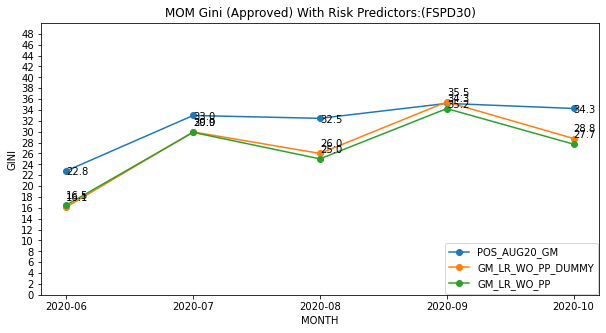

In [109]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(gini_df["MONTH"],gini_df["POS_AUG20_GM"], marker='o', scaley = False, label = "POS_AUG20_GM")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP_DUMMY"], marker='o', scaley = False, label = "GM_LR_WO_PP_DUMMY")
ax1.plot(gini_df["MONTH"],gini_df["GM_LR_WO_PP"], marker='o', scaley = False, label = "GM_LR_WO_PP")

# ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# for y in predictor_list:
#     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


for i, txt in enumerate(gini_df["POS_AUG20_GM"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["POS_AUG20_GM"][i]-0.8))
for i, txt in enumerate(gini_df["GM_LR_WO_PP_DUMMY"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP_DUMMY"][i]+1.2))
for i, txt in enumerate(gini_df["GM_LR_WO_PP"]):
    plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM_LR_WO_PP"][i]+1.2))
    
# for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# for y in predictor_list:
#     for i, txt in enumerate(gini_df[y]):
#         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
plt.legend(loc='lower right', borderaxespad=0.1)
plt.ylim(0,50)
plt.ylabel("GINI")
plt.xlabel("MONTH")
plt.yticks(np.arange(0,50,2))
ax1.set_title("MOM Gini (Approved) With Risk Predictors:(FSPD30)")
plt.show()

# Lifts Chart